In [20]:
import pandas as pd
import numpy as  np
from sqlalchemy import create_engine,inspect,func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from scipy import stats

import matplotlib.pyplot as plt

In [3]:
# Read in both data tables to pandas
engine = create_engine("sqlite:///Data/hawaii.sqlite")
Base = automap_base()

contents = inspect(engine)
Base.prepare(engine,reflect = True)
Base.classes.keys()

['measurement', 'station']

In [7]:
columns_measurement = contents.get_columns('measurement')
display(columns_measurement)

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [8]:
display(contents.get_columns('station'))

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [74]:
#First Date
#session.query(Measurement.date).order_by(Measurement.date).first()

In [75]:
#last Date
#session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [76]:
#session.query(Station.station).all()

In [77]:
measurement_df = pd.read_sql("SELECT * FROM measurement",con = engine)
station_df = pd.read_sql("SELECT * FROM station",con = engine)

#Verify data import
display(measurement_df)
display(station_df)
display(measurement_df.dtypes)
display(measurement_df.count())

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


id           int64
station     object
date        object
prcp       float64
tobs       float64
dtype: object

id         19550
station    19550
date       19550
prcp       18103
tobs       19550
dtype: int64

## Precipitation Analysis

In [78]:

rainfall = pd.read_sql("""
SELECT date AS Date, prcp As Precipitation
FROM measurement 
WHERE Date > DATE('2016-08-23')
ORDER BY Date ASC;
                       """,con = engine).dropna().set_index("Date")
rainfall

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


<AxesSubplot:xlabel='Date'>

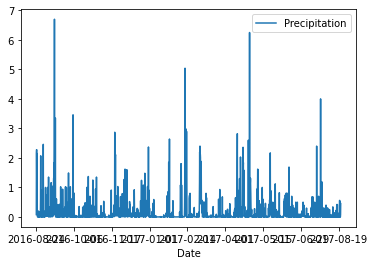

In [79]:
rainfall.plot()

In [80]:
rainfall.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [81]:
station_df["station"].count()

9

In [103]:
#Query most active station

ma = list(np.ravel(pd.read_sql("""
SELECT station
FROM measurement
GROUP BY station
ORDER BY count(prcp) DESC
LIMIT 1;
""",con = engine)))
display(ma)

['USC00519281']

In [105]:
# Query last year of temperature data for most active station
activestation_data = pd.read_sql("""
SELECT tobs AS Temperature
FROM  measurement
WHERE Date > DATE('2016-08-23') AND station = :ma""",params={"ma":ma[0]}, con = engine)
display(activestation_data)

,Temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


<AxesSubplot:ylabel='Frequency'>

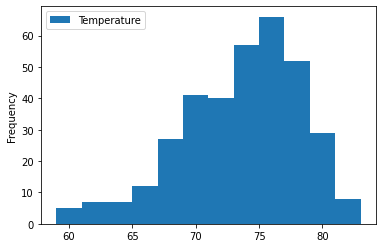

In [106]:
activestation_data.plot.hist(bins = 12)

## Temperature Analysis

In [155]:
# Thank you to stackoverflow user piRSquarted for guidance on merging with duplicate keys
june_temps = pd.read_sql("""
SELECT date AS Jun_date, tobs AS Jun_temp,station
FROM measurement
WHERE strftime("%m",date) = '06'
""",con =engine)
june_temps['cc'] = june_temps.groupby('station').cumcount()
display(june_temps)

,Jun_date,Jun_temp,station,cc
0,2010-06-01,78.0,USC00519397,0
1,2010-06-02,76.0,USC00519397,1
2,2010-06-03,78.0,USC00519397,2
3,2010-06-04,76.0,USC00519397,3
4,2010-06-05,77.0,USC00519397,4
...,...,...,...,...
1695,2017-06-26,79.0,USC00516128,218
1696,2017-06-27,74.0,USC00516128,219
1697,2017-06-28,74.0,USC00516128,220
1698,2017-06-29,76.0,USC00516128,221


In [156]:
# Thank you to stackoverflow user piRSquarted for guidance on merging with duplicate keys
december_temps = pd.read_sql("""
SELECT date AS Dec_date, tobs AS Dec_temp,station
FROM measurement
WHERE strftime("%m",date) = '12';
""",con =engine)
december_temps['cc'] = december_temps.groupby('station').cumcount()
display(december_temps)

,Dec_date,Dec_temp,station,cc
0,2010-12-01,76.0,USC00519397,0
1,2010-12-03,74.0,USC00519397,1
2,2010-12-04,74.0,USC00519397,2
3,2010-12-06,64.0,USC00519397,3
4,2010-12-07,64.0,USC00519397,4
...,...,...,...,...
1512,2016-12-27,71.0,USC00516128,201
1513,2016-12-28,71.0,USC00516128,202
1514,2016-12-29,69.0,USC00516128,203
1515,2016-12-30,65.0,USC00516128,204


In [157]:
temps_merge = pd.merge(december_temps,june_temps, on=['station','cc'],how = 'left').drop('cc',1)

In [158]:
display(temps_merge)

,Dec_date,Dec_temp,station,Jun_date,Jun_temp
0,2010-12-01,76.0,USC00519397,2010-06-01,78.0
1,2010-12-03,74.0,USC00519397,2010-06-02,76.0
2,2010-12-04,74.0,USC00519397,2010-06-03,78.0
3,2010-12-06,64.0,USC00519397,2010-06-04,76.0
4,2010-12-07,64.0,USC00519397,2010-06-05,77.0
...,...,...,...,...,...
1512,2016-12-27,71.0,USC00516128,2017-06-08,75.0
1513,2016-12-28,71.0,USC00516128,2017-06-10,72.0
1514,2016-12-29,69.0,USC00516128,2017-06-11,76.0
1515,2016-12-30,65.0,USC00516128,2017-06-12,74.0


In [159]:
stats.ttest_rel(temps_merge['Jun_temp'],temps_merge['Dec_temp'])

Ttest_relResult(statistic=31.626872614066585, pvalue=5.1149843653202015e-169)

### Temperature Analysis II

In [9]:
Measurement = Base.classes.measurement
session = Session(engine)

In [43]:
def calc_temps(start_date,end_date):
    """Returns temperature statistics for a specifieid date range
    
    Args:
        start_date (string): A date string in the format ''%Y-%m-%d' 'YYYY-MM-DD'
        end_date (string): A date string in the format ''%Y-%m-%d' 'YYYY-MM-DD'
        
    Returns:
        TMIN, TAVG, and TMAX
        """
    return list(np.ravel((
        session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs))
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date))
        .all()))

In [59]:
vacation_temps = calc_temps('2015-02-14','2015-03-01')
print(vacation_temps)

[56.0, 69.75, 77.0]


In [90]:
def plot_temps(tmin,tavg,tmax):
    """Visualize the temperature summary statistics
    
    Args:
        tmin: A numeric data type containing the minimum temperatre
        tavg: A numeric data type containing the average temperature
        tmax: A numeric data type containing the maxiumum temperature
    """
    plt.bar(10,vacation_temps[1],yerr=((vacation_temps[2]-vacation_temps[0])/2))

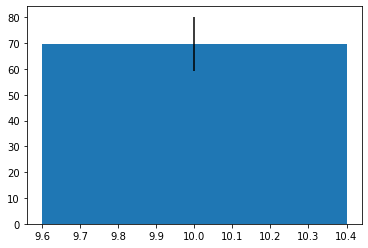

In [92]:
plot_temps(vacation_temps[0],vacation_temps[1],vacation_temps[2])

## Cumulative Rainfall


In [83]:
rainfall = pd.read_sql("""
SELECT station AS Station, SUM(prcp) As Total_Precipitation
FROM measurement 
WHERE date > DATE('2016-08-23')
GROUP BY station
ORDER BY Total_Precipitation DESC;
                       """,con = engine)

In [84]:
rainfall

,Station,Total_Precipitation
0,USC00516128,147.11
1,USC00519281,68.24
2,USC00513117,48.36
3,USC00519523,37.99
4,USC00514830,33.19
5,USC00519397,16.09
6,USC00517948,4.59


## Daily Temperature Normals

In [170]:
def daily_normals(date):
    """Returns observed tmin, tavg, and tmax for a specified day based on historical data; The daily normal temperatures
    
    Args:
        date (str): A date string in the format '%m-%d' ('MM-DD')
    
    Returns:
        A list containing the daily normals, tmin, tavg, and tmax
        
    """
    temp_stats = [func.min(Measurement.tobs), # Minimum  observed temperature
                  func.round(func.avg(Measurement.tobs),0), # average of all observed temperature
                  func.max(Measurement.tobs), # Maximum observed temperature
                  func.strftime('%m-%d',Measurement.date)] # observation date string 'MM-DD'
    
    #Query sqlite database using sqlalchemy
    return list(np.ravel(
        session.query(*temp_stats)
        .filter(func.strftime('%m-%d',Measurement.date) ==date)
        .all()
    ))
daily_normals('01-01')

['62.0', '69.0', '77.0', '01-01']

In [283]:
def date_list(start_date,end_date):
    """Return a list of dates for the specified range, including the start and end date
    
    Args:
        start_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
        end_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
    
    Returns:
        A list of dates in the format '%m-%d'
        
    """
    return list(np.ravel(
        session.query(func.strftime('%m-%d',Measurement.date))
        .filter(func.strftime('%Y-%m-%d',Measurement.date) >= start_date)
        .filter(func.strftime('%Y-%m-%d',Measurement.date) <= end_date)
        .group_by(Measurement.date).all()
    ))

In [285]:
test_dates = date_list('2015-01-25','2015-04-07')
test_dates

['01-25',
 '01-26',
 '01-27',
 '01-28',
 '01-29',
 '01-30',
 '01-31',
 '02-01',
 '02-02',
 '02-03',
 '02-04',
 '02-05',
 '02-06',
 '02-07',
 '02-08',
 '02-09',
 '02-10',
 '02-11',
 '02-12',
 '02-13',
 '02-14',
 '02-15',
 '02-16',
 '02-17',
 '02-18',
 '02-19',
 '02-20',
 '02-21',
 '02-22',
 '02-23',
 '02-24',
 '02-25',
 '02-26',
 '02-27',
 '02-28',
 '03-01',
 '03-02',
 '03-03',
 '03-04',
 '03-05',
 '03-06',
 '03-07',
 '03-08',
 '03-09',
 '03-10',
 '03-11',
 '03-12',
 '03-13',
 '03-14',
 '03-15',
 '03-16',
 '03-17',
 '03-18',
 '03-19',
 '03-20',
 '03-21',
 '03-22',
 '03-23',
 '03-24',
 '03-25',
 '03-26',
 '03-27',
 '03-28',
 '03-29',
 '03-30',
 '03-31',
 '04-01',
 '04-02',
 '04-03',
 '04-04',
 '04-05',
 '04-06',
 '04-07']

In [257]:
test1 =[daily_normals(x) for x in test_dates]
test1

[['63.0', '72.0', '78.0', '03-25'],
 ['64.0', '71.0', '80.0', '03-26'],
 ['63.0', '72.0', '80.0', '03-27'],
 ['59.0', '72.0', '82.0', '03-28'],
 ['58.0', '71.0', '77.0', '03-29'],
 ['62.0', '72.0', '79.0', '03-30'],
 ['61.0', '72.0', '79.0', '03-31'],
 ['60.0', '72.0', '80.0', '04-01'],
 ['53.0', '72.0', '79.0', '04-02'],
 ['55.0', '72.0', '78.0', '04-03'],
 ['58.0', '72.0', '78.0', '04-04'],
 ['61.0', '72.0', '80.0', '04-05'],
 ['67.0', '72.0', '77.0', '04-06'],
 ['63.0', '71.0', '78.0', '04-07']]

In [267]:
def normals_plot(start_date,end_date):
    """Build a pandas dataframe of daily normals for the specified date range, and plot the results
        Args: 
            start_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
            end_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')  
        Return: Visualization of the daily temperature normals
    """
    
    def date_list(start_date,end_date):
        """Return a list of dates for the specified range, including the start and end date
        Args:
            start_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
            end_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
        Returns:
            A list of dates in the format '%m-%d'

        """
        return list(np.ravel(
            session.query(func.strftime('%m-%d',Measurement.date))
            .filter(func.strftime('%Y-%m-%d',Measurement.date) >= start_date)
            .filter(func.strftime('%Y-%m-%d',Measurement.date) <= end_date)
            .group_by(Measurement.date).all()
        ))

    def daily_normals(date):
        """Returns observed tmin, tavg, and tmax for a specified day based on historical data; The daily normal temperatures
        Args:
            date (str): A date string in the format '%m-%d' ('MM-DD')
        Returns:
            A list containing the daily normals, tmin, tavg, and tmax
        """
        #columns to return from the query
        temp_stats = [func.min(Measurement.tobs), # Minimum  observed temperature
                      func.round(func.avg(Measurement.tobs),0), # average of all observed temperature
                      func.max(Measurement.tobs), # Maximum observed temperature
                      func.strftime('%m-%d',Measurement.date)] # observation date string 'MM-DD'

        #Query sqlite database using sqlalchemy
        return list(np.ravel(
            session.query(*temp_stats)
            .filter(func.strftime('%m-%d',Measurement.date) == date)
            .all()
        ))
    def build_df(normals):
        """Returns a pandas dataframe of daily normals
            Args:
                normals (list): A list of daily normals data in the order [tmin,tavg,tmax,date('%m-%d'])
            Returns:
                Pandas dataframe with the date as the index,
                and the column headers 'Minumum Temperatre','Average Temperature','Maximum Temperature',and 'Date'
        """
        
        return (pd.DataFrame(normals,columns = ['Minimum Temperature','Average Temperature',
                                                'Maximum Temperature','Date'])
                .astype({'Minimum Temperature': float,'Average Temperature': float,'Maximum Temperature': float})
                .set_index('Date'))
    
    specified_range = date_list(start_date,end_date)
    return specified_range
    #normals = [daily_normals(date) for date in specified_range]
   # return normals
    #normals_df = build_df(normals)
    
   # return normals_df.plot.area()

In [268]:
normals_plot('01-01-2016','01-14-2016')

[]

In [286]:
def date_list(start_date,end_date):
    """Return a list of dates for the specified range, including the start and end date
        Args:
            start_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
            end_date (str): The date of the range, in the format '%Y-%m-%d' ('YYYY-MM-DD')
        Returns:
            A list of dates in the format '%m-%d'
    """
    return list(np.ravel(
        session.query(func.strftime('%m-%d',Measurement.date))
        .filter(func.strftime('%Y-%m-%d',Measurement.date) >= start_date)
        .filter(func.strftime('%Y-%m-%d',Measurement.date) <= end_date)
        .group_by(Measurement.date).all()
    ))
    
date_list('01-01-2016','01-14-2016')

[]

In [274]:
testdf.dtypes


Minimum Temperature    float64
Average Temperature    float64
Maximum Temperature    float64
dtype: object

In [230]:
testdf = testdf.astype({'Minimum Temperature': float,'Average Temperature': float,'Maximum Temperature': float})
#testdf.plot.area()

In [231]:
testdf.dtypes

Minimum Temperature    float64
Average Temperature    float64
Maximum Temperature    float64
dtype: object

<AxesSubplot:xlabel='Date'>

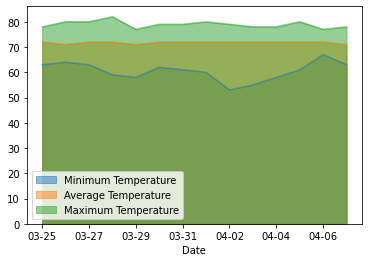

In [236]:
testdf.plot.area(stacked = False)

In [235]:
testdf

,Minimum Temperature,Average Temperature,Maximum Temperature
Date,,,
03-25,63.0,72.0,78.0
03-26,64.0,71.0,80.0
03-27,63.0,72.0,80.0
03-28,59.0,72.0,82.0
03-29,58.0,71.0,77.0
03-30,62.0,72.0,79.0
03-31,61.0,72.0,79.0
04-01,60.0,72.0,80.0
04-02,53.0,72.0,79.0
